In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn

import glob
import sys

from math import *
import pickle

from sklearn.mixture import GaussianMixture

from IPython import display
import time

from PIL import Image

import copy
import subprocess as sp

def tovar(x):
    return torch.cuda.FloatTensor(x)

def toivar(x):
    return torch.cuda.LongTensor(x)

In [2]:
def mkDataset(N=1, d=1, seed=1, pts=5000):
  np.random.seed(seed)
  mu = np.random.rand(N,d)*12-6
  
  idx = np.random.randint(N, size=(pts,))
  
  return np.random.randn(pts,d) + mu[idx], mu

In [3]:
def addSubData(hist, x, p, dim, maxdim, N, idx):
    if dim<maxdim:
        xidx = np.clip((N*(x[:,dim]+12)/24), 0, N-1).astype(np.int32)
        for i in range(N):
            keep = xidx == i
            addSubData(hist, x[keep], p[keep], dim+1, maxdim, N, idx + i*(N**dim))
    else:
        hist[idx] = np.sum(p)

def estimate_Nd_KL(x, y, p, N=20):
    d = x.shape[1]

    histx = np.zeros((N**d))
    histy = np.zeros((N**d))
    
    addSubData(histx, x, np.ones(x.shape[0]), 0, d, N, 0)

    addSubData(histy, y, p, 0, d, N, 0)

    histx = histx / np.sum(histx)
    histy = histy / np.sum(histy)
    
    fisher = 2*acos(np.sum(np.sqrt(histx*histy)))
    
    nonzero = (histx>0)
    histx = histx[nonzero]
    histy = histy[nonzero]
    
    histy = histy + 1e-32
    histy = histy / np.sum(histy)
    histx = histx / np.sum(histx)

    KL = -np.sum(histx*np.log(histy/histx))

    return KL, fisher  

In [4]:
def EvalGMM(N=4, d=2, seed=1, pts=50000):
    xall, mu = mkDataset(N=N, d=d, seed=seed, pts=pts + 400000)

    x = xall[0:pts]
    xtrue = xall[pts:]

    mixmodel = GaussianMixture(n_components=10)
    mixmodel.fit(x)
    y, _ = mixmodel.sample(400000)

    return estimate_Nd_KL(xtrue,y,np.ones(y.shape[0]))

def EvalEmpirical(N=4, d=2, seed=1, pts=50000, R=20):
    xall, mu = mkDataset(N=N, d=d, seed=seed, pts=pts + 400000)

    x = xall[0:pts]
    xtrue = xall[pts:]

    return estimate_Nd_KL(xtrue,x,np.ones(x.shape[0]), N=R)

In [12]:
Ds = []
for d in range(1,5):
    print("d=%d" % d)
    Ns = []
    for N in range(1,11):
        print("N=%d" % N)
        pts = []
        for seed in range(1,6):
            KL, fisher = EvalGMM(N, d, seed, pts=5000)
            print(KL)
            pts.append(np.array([KL,fisher]))
        Ns.append(np.array(pts))
    Ds.append(np.array(Ns))
Ds = np.array(Ds)

d=1
N=1
0.001434981703954667
0.0035273672417401713
0.0035035178943827057
0.0034498980228426495
0.00494716826431083
N=2
0.002562248191551715
0.002864569670314738
0.006989891950650592
0.003964840247970311
0.004090356205354475
N=3
0.0025513703821394527
0.0029759329071930574
0.00540549069055435
0.0013852850149422842
0.002469981247532653
N=4
0.0016791854149310124
0.0029699965637749823
0.0005918221721280537
0.002838180419460874
0.006006502471281322
N=5
0.004041507086394763
0.002008929286335308
0.00572664402357222
0.0016772829753642139
0.0008070979862061548
N=6
0.0013342641399962537
0.0007369398253192098
0.003877887437401666
0.002767722493830712
0.005945823572856057
N=7
0.0014136102676999623
0.0012264469743959144
0.0034043029762192856
0.0034359719271367106
0.0023226919040792776
N=8
0.0023687591078342587
0.0017577588334581793
0.001704029115311559
0.0025288504504404055
0.0032590428070278653
N=9
0.0030196231445896804
0.0011843897000176626
0.0031962706836123605
0.0032333333199780585
0.00622104450

In [9]:
Ds.shape

(4, 10, 5, 2)

In [34]:
mu_D3 = np.mean(Ds,axis=2)
std_D3 = np.std(Ds,axis=2)

In [13]:
np.save("gmm_Ds_5k.npy", Ds)

In [14]:
Ds = []
for d in range(1,5):
    print("d=%d" % d)
    Ns = []
    for N in range(1,11):
        print("N=%d" % N)
        pts = []
        for seed in range(1,6):
            KL, fisher = EvalEmpirical(N, d, seed, R=20, pts=5000)
            pts.append(np.array([KL,fisher]))
        Ns.append(np.array(pts))
    Ds.append(np.array(Ns))
Ds = np.array(Ds)

d=1
N=1
N=2
N=3
N=4
N=5
N=6
N=7
N=8
N=9
N=10
d=2
N=1
N=2
N=3
N=4
N=5
N=6
N=7
N=8
N=9
N=10
d=3
N=1
N=2
N=3
N=4
N=5
N=6
N=7
N=8
N=9
N=10
d=4
N=1
N=2
N=3
N=4
N=5
N=6
N=7
N=8
N=9
N=10


In [15]:
np.save("emp_Ds_5k.npy", Ds)

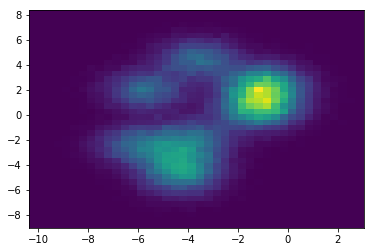

In [25]:
xall, mu = mkDataset(N=10, d=2, seed=1, pts=100000)
plt.hist2d(xall[:,0],xall[:,1],40)
plt.show()

In [42]:
from sklearn.datasets import make_swiss_roll

In [78]:
xall = make_swiss_roll(n_samples=105000)[0]*0.75

x = xall[0:5000]
xtrue = xall[5000:]

mixmodel = GaussianMixture(n_components=10)
mixmodel.fit(x)
y, _ = mixmodel.sample(100000)

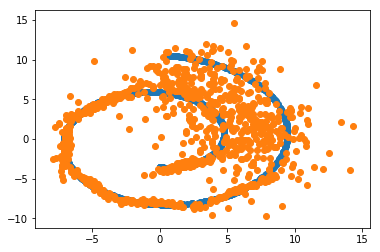

In [79]:
plt.scatter(xall[::100,0], xall[::100,2])
plt.scatter(y[::100,0], y[::100,2])
plt.show()

In [80]:
xall[1].shape

(3,)

In [81]:
estimate_Nd_KL(xtrue,y,np.ones(y.shape[0]))

0.8747944583707264